In [423]:
#!pip install --ignore-installed --upgrade tensorflow 
#!pip install opencv-python
#!pip install --upgrade albumentations --user
#!pip install pandas
#!pip install numpy
#!pip install matplotlib

In [424]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import albumentations as A # used for image augmentation
from PIL import Image #used for importing images
import re
import os,glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [425]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [426]:
data = pd.read_csv('./Genshin_Dataset.csv')
data.head(24)

,Name,Model,Region,Vision,Weapon,Revenue,Year Released
0,Albedo,https://i.postimg.cc/vHqgw9cj/unnamed.jpg,Mondstadt,Geo,Sword,"$11,816,107",2021
1,Ayaka,https://i.postimg.cc/mZP9x58Q/ayaka.jpg,Inazuma,Cryo,Sword,"$16,451,006",2021
2,Ayato,https://i.postimg.cc/3JpDNDMN/ayato.jpg,Inazuma,Hydro,Sword,"$14,481,796",2022
3,Childe (Tartaglia),https://i.postimg.cc/RZBJHV9R/childe.jpg,Liyue,Hydro,Bow,"$13,443,619",2020
4,Cyno,https://i.postimg.cc/bNHN40cx/cyno.jpg,Sumeru,Electro,Polearm,"$13,797,833",2022
5,Eula,https://i.postimg.cc/NMHQDmkr/eula.jpg,Mondstadt,Cryo,Claymore,"$12,619,390",2021
6,Ganyu,https://i.postimg.cc/wM5g8zPq/ganyu.jpg,Liyue,Cryo,Bow,"$15,669,918",2021
7,Hu Tao,https://i.postimg.cc/6pW5K7tD/HuTao.jpg,Liyue,Pyro,Polearm,"$12,481,634",2021
8,Itto,https://i.postimg.cc/NGRgr803/Itto.jpg,Inazuma,Geo,Claymore,"$13,404,072",2022
9,Kazuha,https://i.postimg.cc/NFvBzFdC/kazuha.jpg,Inazuma,Anemo,Sword,"$9,807,112",2021


In [427]:
data = data.drop(columns = 'Model')

data.head()

,Name,Region,Vision,Weapon,Revenue,Year Released
0,Albedo,Mondstadt,Geo,Sword,"$11,816,107",2021
1,Ayaka,Inazuma,Cryo,Sword,"$16,451,006",2021
2,Ayato,Inazuma,Hydro,Sword,"$14,481,796",2022
3,Childe (Tartaglia),Liyue,Hydro,Bow,"$13,443,619",2020
4,Cyno,Sumeru,Electro,Polearm,"$13,797,833",2022


In [428]:
data = data.replace('Childe (Tartaglia)', 'Childe')

In [429]:
revenues = data['Revenue']
revenues = revenues.map(lambda x: int(re.sub(",", "", x[1:]))) # removes $ and commas from the revenue
data['Revenue Value'] = revenues

data.head()

,Name,Region,Vision,Weapon,Revenue,Year Released,Revenue Value
0,Albedo,Mondstadt,Geo,Sword,"$11,816,107",2021,11816107
1,Ayaka,Inazuma,Cryo,Sword,"$16,451,006",2021,16451006
2,Ayato,Inazuma,Hydro,Sword,"$14,481,796",2022,14481796
3,Childe,Liyue,Hydro,Bow,"$13,443,619",2020,13443619
4,Cyno,Sumeru,Electro,Polearm,"$13,797,833",2022,13797833


In [430]:
# Summary Statistics
minimum = min(data['Revenue Value'])
maximum = max(data['Revenue Value'])
mean = data['Revenue Value'].mean()
median = data['Revenue Value'].median()
std = data['Revenue Value'].std()


print("Minimum revenue a character made: ", minimum)
print("Maximum revenue a character made: ", maximum)
print("Average revenue made across all characters: ", mean)
print("Median revenue made across all characters: ", median)
print("Standard Deviation of renevues across all characters: ", std)

Minimum revenue a character made:  6825814
Maximum revenue a character made:  33020905
Average revenue made across all characters:  15416701.625
Median revenue made across all characters:  13423845.5
Standard Deviation of renevues across all characters:  7350760.064221594


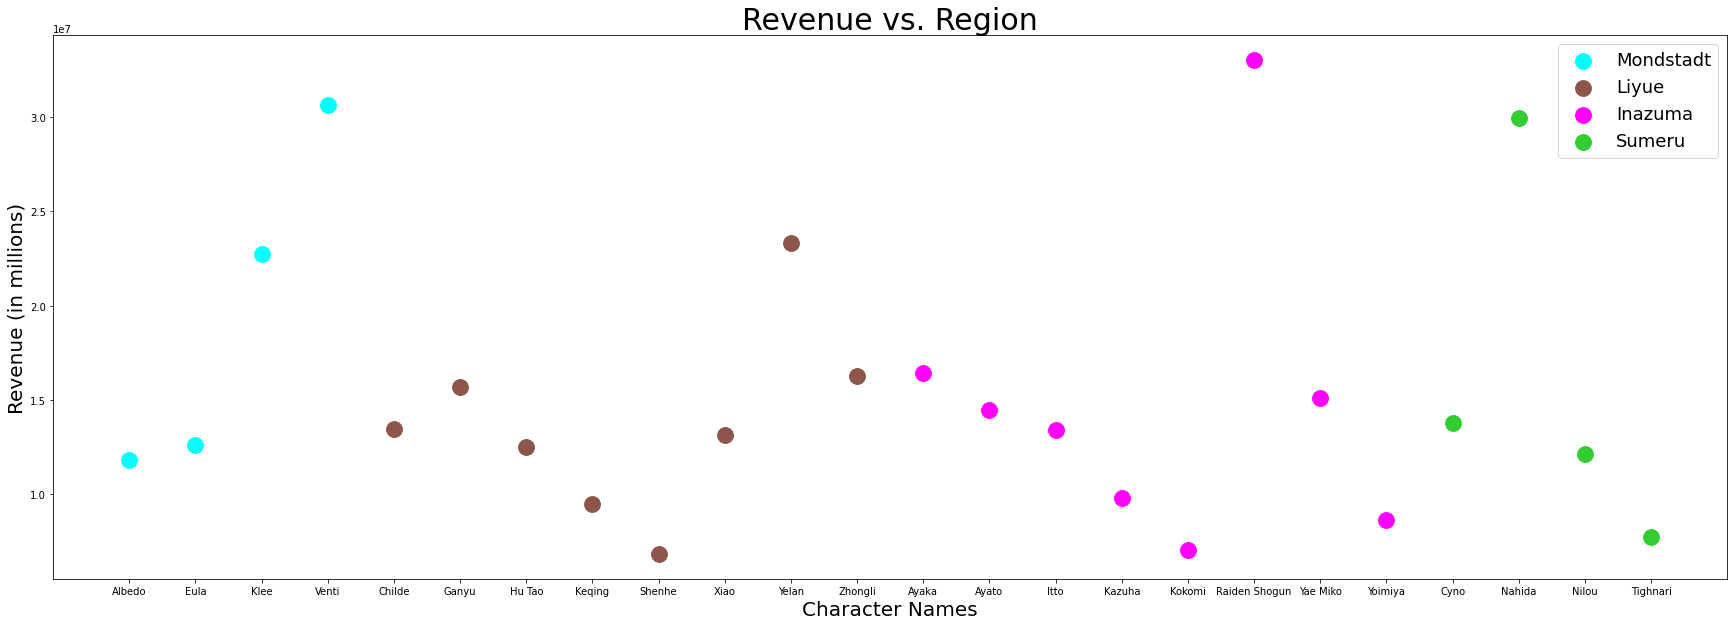

In [431]:
# Scatter plot comparing Region and Revenue
mondstadt_names = []
mondstadt_revs = []

liyue_names = []
liyue_revs = []

inazuma_names = []
inazuma_revs = []

sumeru_names = []
sumeru_revs = []

for row, col in data.iterrows():
    if col['Region'] == 'Mondstadt':
        mondstadt_names.append(col['Name'])
        mondstadt_revs.append(col['Revenue Value'])
    elif col['Region'] == 'Liyue':
        liyue_names.append(col['Name'])
        liyue_revs.append(col['Revenue Value'])
    elif col['Region'] == 'Inazuma':
        inazuma_names.append(col['Name'])
        inazuma_revs.append(col['Revenue Value'])
    else: 
        sumeru_names.append(col['Name'])
        sumeru_revs.append(col['Revenue Value'])
        
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.scatter(mondstadt_names, mondstadt_revs, c = 'aqua', label = 'Mondstadt', s = 250)
ax.scatter(liyue_names, liyue_revs, c = 'tab:brown', label = 'Liyue', s = 250)
ax.scatter(inazuma_names, inazuma_revs, c = 'fuchsia', label = 'Inazuma', s = 250)
ax.scatter(sumeru_names, sumeru_revs, c = 'limegreen', label = 'Sumeru', s = 250)

ax.set_title('Revenue vs. Region', fontsize = 30)
ax.set_xlabel('Character Names', fontsize = 20)
ax.set_ylabel('Revenue (in millions)', fontsize = 20)
ax.legend(prop = ({'size' : 18}), loc = 1)

plt.show()

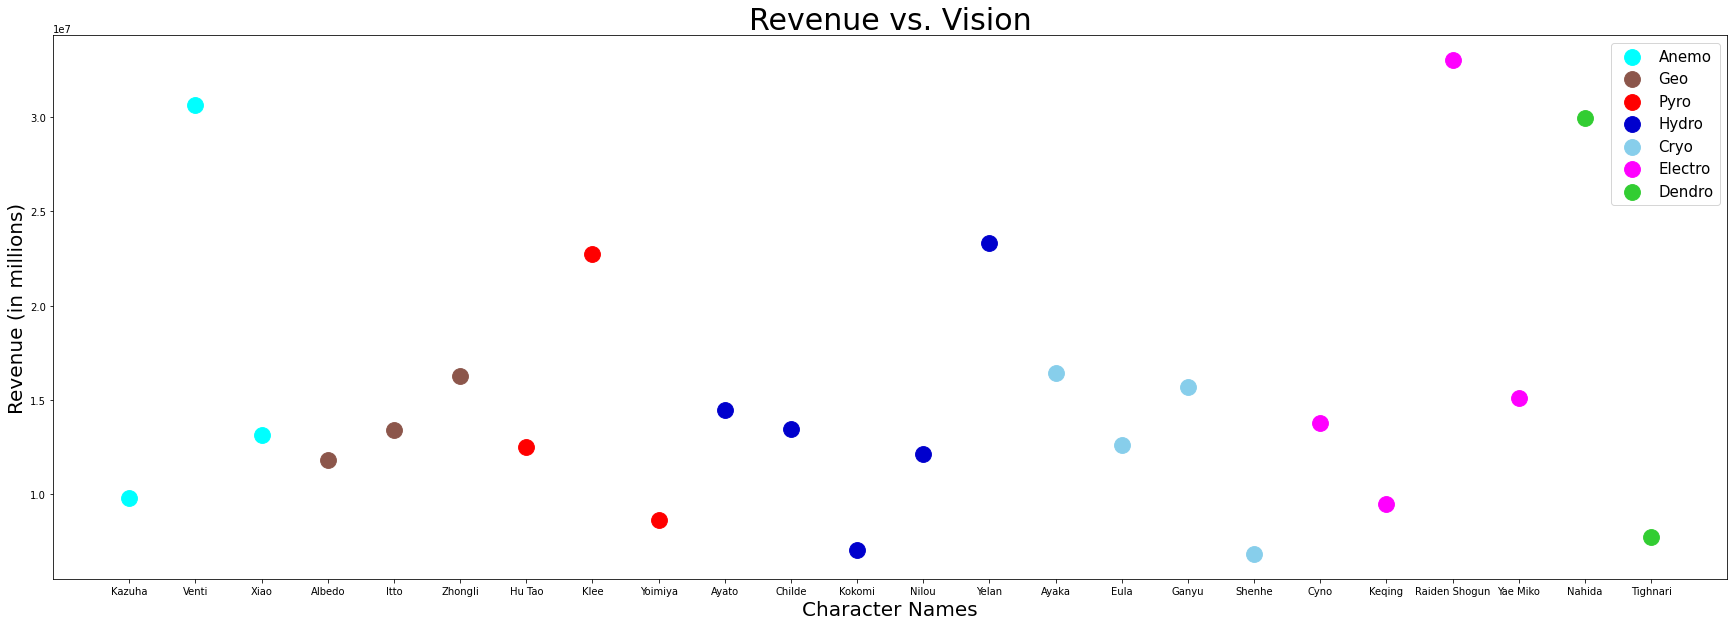

In [432]:
# Scatter plot comparing Vision and Revenue
anemo_names = []
anemo_revs = []

geo_names = []
geo_revs = []

pyro_names = []
pyro_revs = []

hydro_names = []
hydro_revs = []

cryo_names = []
cryo_revs = []

electro_names = []
electro_revs = []

dendro_names = []
dendro_revs = []

for row, col in data.iterrows():
    if col['Vision'] == 'Anemo':
        anemo_names.append(col['Name'])
        anemo_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Geo':
        geo_names.append(col['Name'])
        geo_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Pyro':
        pyro_names.append(col['Name'])
        pyro_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Hydro':
        hydro_names.append(col['Name'])
        hydro_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Cryo':
        cryo_names.append(col['Name'])
        cryo_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Electro':
        electro_names.append(col['Name'])
        electro_revs.append(col['Revenue Value'])
    else: 
        dendro_names.append(col['Name'])
        dendro_revs.append(col['Revenue Value'])
        
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.scatter(anemo_names, anemo_revs, c = 'aqua', label = 'Anemo', s = 250)
ax.scatter(geo_names, geo_revs, c = 'tab:brown', label = 'Geo', s = 250)
ax.scatter(pyro_names, pyro_revs, c = 'red', label = 'Pyro', s = 250)
ax.scatter(hydro_names, hydro_revs, c = 'mediumblue', label = 'Hydro', s = 250)
ax.scatter(cryo_names, cryo_revs, c = 'skyblue', label = 'Cryo', s = 250)
ax.scatter(electro_names, electro_revs, c = 'fuchsia', label = 'Electro', s = 250)
ax.scatter(dendro_names, dendro_revs, c = 'limegreen', label = 'Dendro', s = 250)

ax.set_title('Revenue vs. Vision', fontsize = 30)
ax.set_xlabel('Character Names', fontsize = 20)
ax.set_ylabel('Revenue (in millions)', fontsize = 20)
ax.legend(prop = ({'size' : 15}), loc = 1)

plt.show()

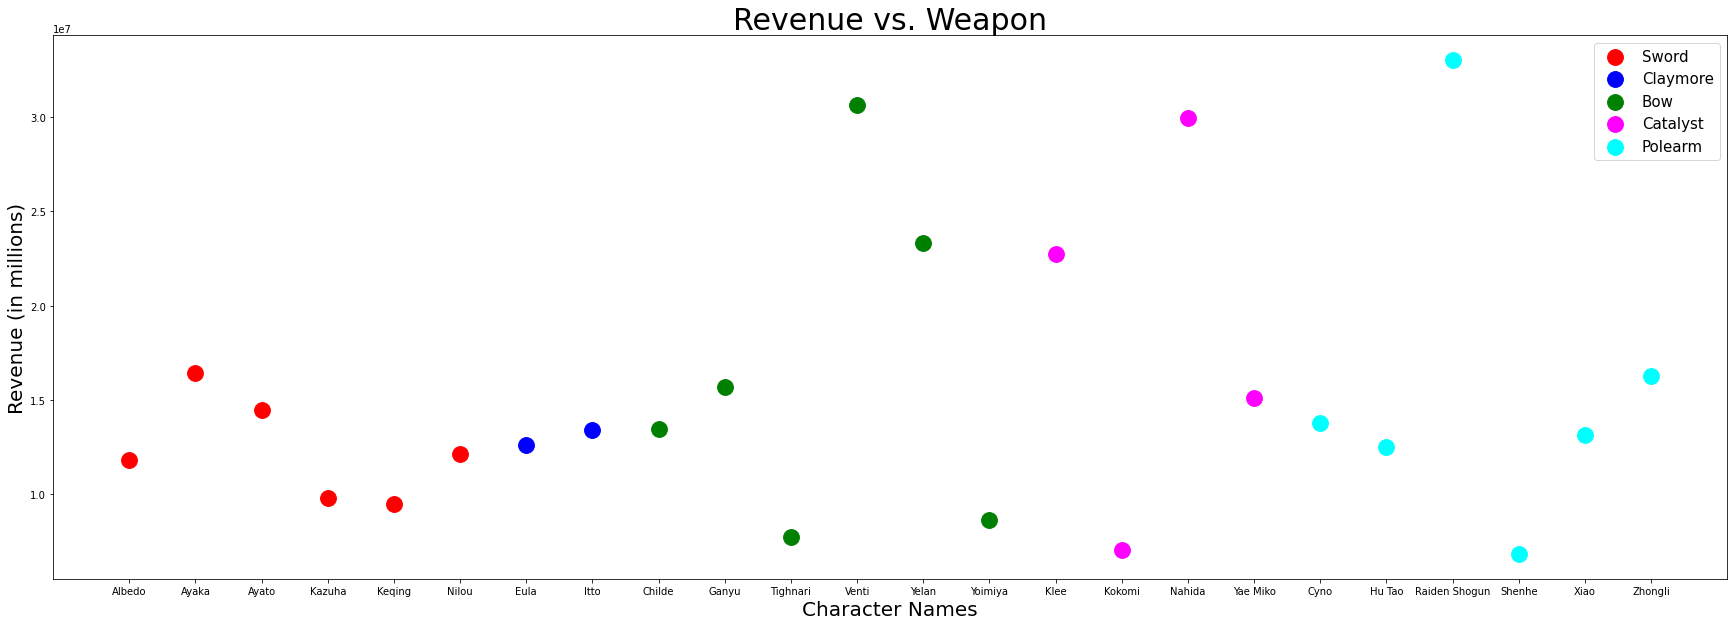

In [433]:
# Scatter plot comparing Weapon and Revenue
sword_names = []
sword_revs = []

claymore_names = []
claymore_revs = []

bow_names = []
bow_revs = []

catalyst_names = []
catalyst_revs = []

polearm_names = []
polearm_revs = []

for row, col in data.iterrows():
    if col['Weapon'] == 'Sword':
        sword_names.append(col['Name'])
        sword_revs.append(col['Revenue Value'])
    elif col['Weapon'] == 'Claymore':
        claymore_names.append(col['Name'])
        claymore_revs.append(col['Revenue Value'])
    elif col['Weapon'] == 'Bow':
        bow_names.append(col['Name'])
        bow_revs.append(col['Revenue Value'])
    elif col['Weapon'] == 'Catalyst':
        catalyst_names.append(col['Name'])
        catalyst_revs.append(col['Revenue Value'])
    else: 
        polearm_names.append(col['Name'])
        polearm_revs.append(col['Revenue Value'])
        
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.scatter(sword_names, sword_revs, c = 'red', label = 'Sword', s = 250)
ax.scatter(claymore_names, claymore_revs, c = 'blue', label = 'Claymore', s = 250)
ax.scatter(bow_names, bow_revs, c = 'green', label = 'Bow', s = 250)
ax.scatter(catalyst_names, catalyst_revs, c = 'magenta', label = 'Catalyst', s = 250)
ax.scatter(polearm_names, polearm_revs, c = 'cyan', label = 'Polearm', s = 250)

ax.set_title('Revenue vs. Weapon', fontsize = 30)
ax.set_xlabel('Character Names', fontsize = 20)
ax.set_ylabel('Revenue (in millions)', fontsize = 20)
ax.legend(prop = ({'size' : 15}), loc = 1)

plt.show()

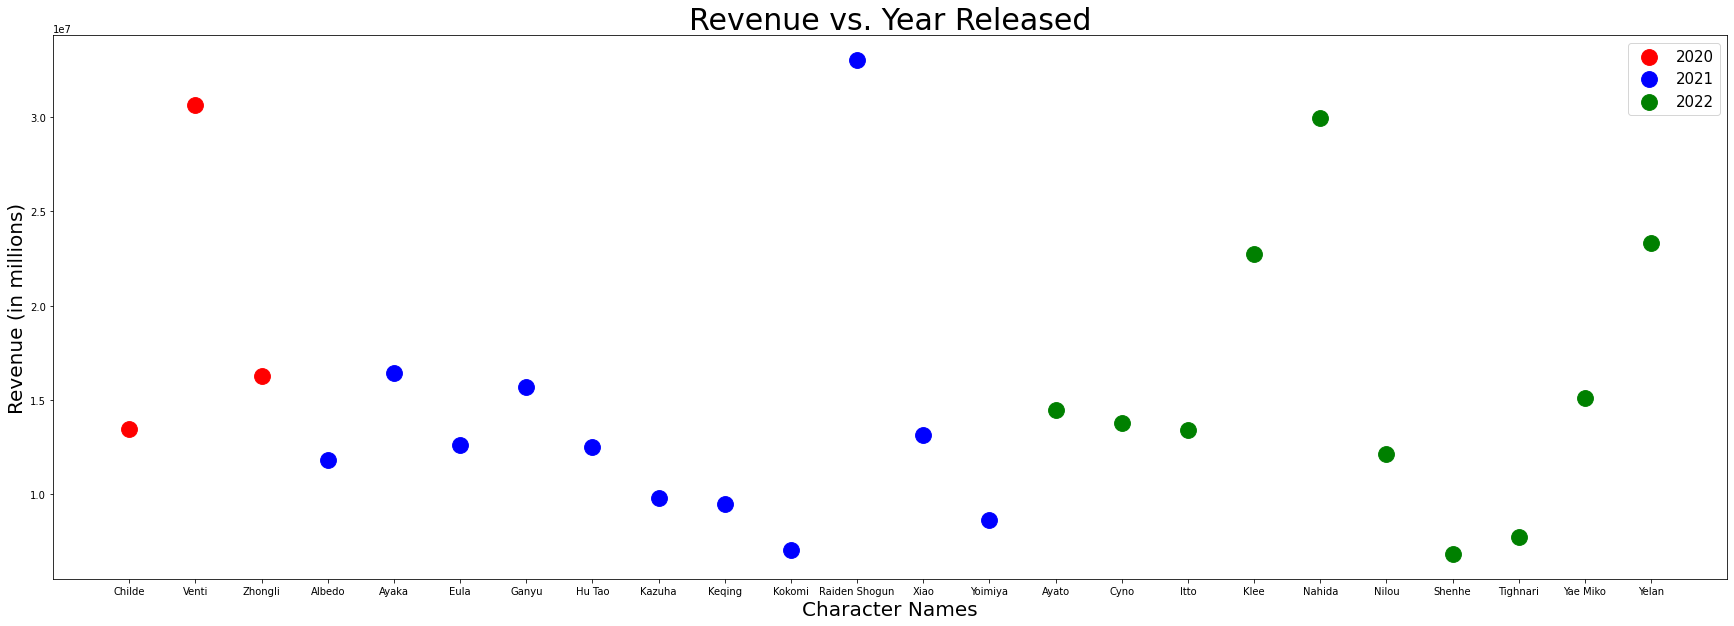

In [434]:
# Scatter plot comparing Weapon and Revenue
twenty_names = []
twenty_revs = []

twentyone_names = []
twentyone_revs = []

twentytwo_names = []
twentytwo_revs = []

for row, col in data.iterrows():
    if col['Year Released'] == 2020:
        twenty_names.append(col['Name'])
        twenty_revs.append(col['Revenue Value'])
    elif col['Year Released'] == 2021:
        twentyone_names.append(col['Name'])
        twentyone_revs.append(col['Revenue Value'])
    else: 
        twentytwo_names.append(col['Name'])
        twentytwo_revs.append(col['Revenue Value'])
        
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.scatter(twenty_names, twenty_revs, c = 'red', label = '2020', s = 250)
ax.scatter(twentyone_names, twentyone_revs, c = 'blue', label = '2021', s = 250)
ax.scatter(twentytwo_names, twentytwo_revs, c = 'green', label = '2022', s = 250)

ax.set_title('Revenue vs. Year Released', fontsize = 30)
ax.set_xlabel('Character Names', fontsize = 20)
ax.set_ylabel('Revenue (in millions)', fontsize = 20)
ax.legend(prop = ({'size' : 15}), loc = 1)

plt.show()

In [435]:
# using the mean revenue a character made, we divided the data into 2 classifications 
# each classification represents below $15.4M (0) and above or equal to $15.4M (1)
for row, col in data.iterrows():
    if col['Revenue Value'] <= mean:
        data.at[row, 'Revenue Classifier'] = 0
    else:
        data.at[row, 'Revenue Classifier'] = 1

data.head()

,Name,Region,Vision,Weapon,Revenue,Year Released,Revenue Value,Revenue Classifier
0,Albedo,Mondstadt,Geo,Sword,"$11,816,107",2021,11816107,0.0
1,Ayaka,Inazuma,Cryo,Sword,"$16,451,006",2021,16451006,1.0
2,Ayato,Inazuma,Hydro,Sword,"$14,481,796",2022,14481796,0.0
3,Childe,Liyue,Hydro,Bow,"$13,443,619",2020,13443619,0.0
4,Cyno,Sumeru,Electro,Polearm,"$13,797,833",2022,13797833,0.0


In [436]:
# Proving the graphs above have a small correlation
for row, col in data.iterrows():
    if col['Region'] == 'Mondstadt':
        data.at[row, 'Region Encoding'] = 0
    elif col['Region'] == 'Liyue':
        data.at[row, 'Region Encoding'] = 1
    elif col['Region'] == 'Inazuma':
        data.at[row, 'Region Encoding'] = 2
    else:
        data.at[row, 'Region Encoding'] = 3

print(data['Region Encoding'].corr(data['Revenue Classifier']))

-0.1846372364689991


In [437]:
for row, col in data.iterrows():
    if col['Vision'] == 'Anemo':
        data.at[row, 'Vision Encoding'] = 0
    elif col['Vision'] == 'Geo':
        data.at[row, 'Vision Encoding'] = 1
    elif col['Vision'] == 'Pyro':
        data.at[row, 'Vision Encoding'] = 2
    elif col['Vision'] == 'Hydro':
        data.at[row, 'Vision Encoding'] = 3
    elif col['Vision'] == 'Cryo':
        data.at[row, 'Vision Encoding'] = 4
    elif col['Vision'] == 'Electro':
        data.at[row, 'Vision Encoding'] = 5
    else:
        data.at[row, 'Vision Encoding'] = 6

print(data['Vision Encoding'].corr(data['Revenue Classifier']))

0.048412291827592706


In [438]:
for row, col in data.iterrows():
    if col['Weapon'] == 'Sword':
        data.at[row, 'Weapon Encoding'] = 0
    elif col['Weapon'] == 'Claymore':
        data.at[row, 'Weapon Encoding'] = 1
    elif col['Weapon'] == 'Bow':
        data.at[row, 'Vision Encoding'] = 2
    elif col['Weapon'] == 'Catalyst':
        data.at[row, 'Vision Encoding'] = 3
    else:
        data.at[row, 'Vision Encoding'] = 4

print(data['Weapon Encoding'].corr(data['Revenue Classifier']))

-0.21821789023599236


In [439]:
for row, col in data.iterrows():
    if col['Year Released'] == 2020:
        data.at[row, 'Year Encoding'] = 0
    elif col['Year Released'] == 2021:
        data.at[row, 'Year Encoding'] = 1
    else:
        data.at[row, 'Year Encoding'] = 2

print(data['Year Encoding'].corr(data['Revenue Classifier']))

-0.17440828807877892


In [440]:
# given the filepath to the image, we can visualize the image
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [441]:
# transformations using albumentations library
vertical_transform = A.Compose([A.VerticalFlip(p=1)])
horizontal_transform = A.Compose([A.HorizontalFlip(p=1)])

In [442]:
images_arr = [] # array of images
revenue_arr = [] # array of revenues for each character
counter = 0

# iterates over the character images in the folder 
# returns a tuple where the 3rd element is a list of the character names
for e_image in os.walk('./Genshin Characters/'):

    # iterates over the list of the character names
    for img_name in e_image[2]:
        file_path = './Genshin Characters/{}'.format(img_name)
        image = cv2.imread(file_path) # converts the image to color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (100, 250)) # resizing images to same size
        
        # the following code changes pixels to numeric data
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        
        # transform function takes in the image as the parameter
        # the output is a dictionary with 'image' as the key and the transformed image as the value
        # so, we extract the value by giving it the key
        vertical_image = vertical_transform(image=image)['image'] 
        horizontal_image = horizontal_transform(image=image)['image']
       
        images_arr.append(image)
        images_arr.append(vertical_image)
        images_arr.append(horizontal_image)
        
        revenue_arr.append(data['Revenue Classifier'][counter])
        revenue_arr.append(data['Revenue Classifier'][counter])
        revenue_arr.append(data['Revenue Classifier'][counter])
        counter += 1

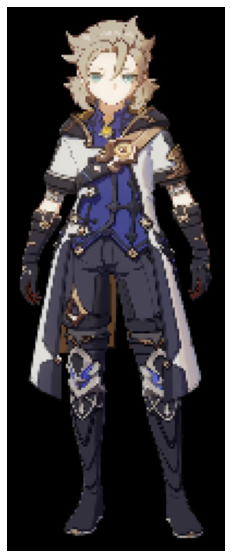

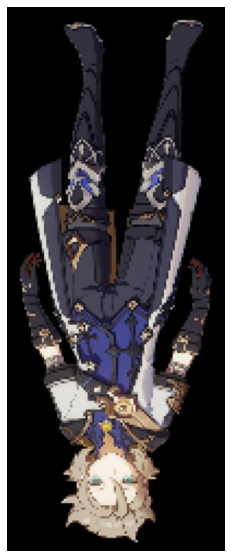

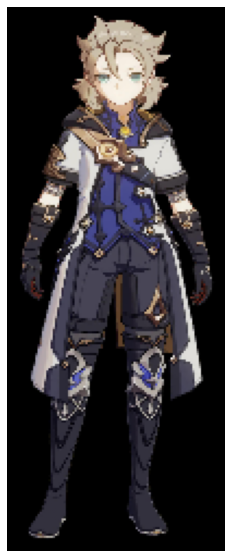

In [443]:
for image in images_arr[:3]:
    visualize(image)

In [444]:
print(len(revenue_arr))
print(len(images_arr))

72
72


In [445]:
images_arr = np.array(images_arr).astype(np.float32)

In [446]:
revenue_arr = list(map(lambda x: x.astype(np.int32), revenue_arr))

In [447]:
img_train, img_test, rev_train, rev_test = train_test_split(images_arr, revenue_arr, test_size=0.2, 
                                                            shuffle = True, random_state = 20)

In [448]:
img_train.shape

(57, 250, 100, 3)

In [449]:
base_model = keras.applications.Xception (
    weights = 'imagenet',
    input_shape = (250, 100, 3),
    include_top = False
)

In [450]:
base_model.trainable = False

In [451]:
inputs = keras.Input(shape = (250, 100, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# you cna use cross entropy as your loss
# your final layer a single output neuron -> that holds what ever the regression prediction is
# for classification your final layer is n_classes of neurons -> where accuracy is argmax(final_layer) is the class


In [452]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics = [keras.metrics.BinaryAccuracy()])

In [453]:
print(len(rev_train))
print(len(img_train))

57
57


In [ ]:
model.fit(img_train, np.array(rev_train), epochs = 5, validation_data = (img_test, np.array(rev_test)))

Epoch 1/5
2/2 [==============================] - 11s 6s/step - loss: 0.7125 - binary_accuracy: 0.6316 - val_loss: 0.5460 - val_binary_accuracy: 0.8000
Epoch 2/5
2/2 [==============================] - 10s 5s/step - loss: 0.6533 - binary_accuracy: 0.6316 - val_loss: 0.5686 - val_binary_accuracy: 0.8000
Epoch 3/5
2/2 [==============================] - 11s 5s/step - loss: 0.6259 - binary_accuracy: 0.6316 - val_loss: 0.6018 - val_binary_accuracy: 0.8000
Epoch 4/5
2/2 [==============================] - 10s 5s/step - loss: 0.6032 - binary_accuracy: 0.6316 - val_loss: 0.6063 - val_binary_accuracy: 0.7333
Epoch 5/5


In [ ]:
#model.predict(NEW CHARACTER IMAGE IF WE CAN GET IT)